Q2. Face Recognition Using K-NN

In [3]:
import pandas as pd
import numpy as np
import cv2
from collections import Counter

Train test split

In [3]:
# Function to create training and testing splits
def train_test_split(normalised_dataset, num_training_images=150, random_state=None):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()

    for _, group in normalised_dataset.groupby('label'):
        train_group = group.sample(n=num_training_images, random_state=random_state)
        test_group = group.drop(train_group.index)

        train_set = pd.concat([train_set, train_group])
        test_set = pd.concat([test_set, test_group])

    # Shuffle the training and test sets to ensure randomness
    train_set = train_set.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_set = test_set.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Split train_set into X_train and y_train
    x_train = train_set.drop('label', axis=1)  
    y_train = train_set['label']  

    # Split test_set into X_test and y_test
    x_test = test_set.drop('label', axis=1)  
    y_test = test_set['label']  

    # Convert feature columns to float and round to 5 decimal points
    x_train = x_train.astype(float).round(5)
    x_test = x_test.astype(float).round(5)

    return x_test, y_test, x_train, y_train

KNN function

Cosine similarity

In [6]:
# Cosine Similarity
def calculate_cosine(main_point, x_train, y_train, k):
    similarities_and_indices = []  # List to store cosine similarities and corresponding indices
    
    # Calculate cosine similarity between main_point and each point in x_train
    for idx, point in enumerate(x_train):
        dot_product = np.dot(main_point, point)
        magnitude_main = np.linalg.norm(main_point)
        magnitude_point = np.linalg.norm(point)
        
        if magnitude_main != 0 and magnitude_point != 0:
            similarity = dot_product / (magnitude_main * magnitude_point)
        else:
            similarity = 0  # If any magnitude is 0, set similarity to 0
        
        similarities_and_indices.append((similarity, idx))  # Append similarity and index
    
    # Sort similarities
    similarities_and_indices.sort(reverse=True)
    
    # Get top k nearest neighbors
    k_nearest_neighbors_indices = [idx for _, idx in similarities_and_indices[:k]]
    
    # Get labels of k nearest neighbors from y_train
    labels = [y_train[idx] for idx in k_nearest_neighbors_indices]
    
    # Count occurrences of each label
    label_counts = Counter(labels)
    
    # Get the label with the highest count
    majority_label = max(label_counts, key=label_counts.get)
    
    # Return the majority label
    return majority_label

Euclidean distance

In [1]:
# Euclidean distance
def calculate_euclidean(main_point, x_train, y_train, k):
    distances_and_indices = []  # List to store distances and corresponding indices
    
    for idx, point in enumerate(x_train):
        squared_diff = np.square(main_point - point)
        sum_squared_diff = np.sum(squared_diff)
        distance = np.sqrt(sum_squared_diff)
        distances_and_indices.append((distance, idx))  # Append distance and index
    
    # sorting distances
    distances_and_indices.sort()
    
    # Getting top k nearest neighbors
    k_nearest_neighbors_indices = [idx for _, idx in distances_and_indices[:k]]
    
    # Get labels of k nearest neighbors from y_train
    labels = [y_train[idx] for idx in k_nearest_neighbors_indices]
    
    # Count occurrences of each label
    label_counts = Counter(labels)
    
    # Get the label with the highest count
    majority_label = max(label_counts, key=label_counts.get)
    
    # Return the majority label
    return majority_label


In [12]:
# Function to calculate accuracy
def calculate_accuracy(predictions, true_labels):
    correct_count = 0
    
    # Iterate through each predicted label and true label
    for pred, true in zip(predictions, true_labels):
        if pred == true:
            correct_count += 1
    
    # Calculate accuracy 
    accuracy = correct_count / len(true_labels)
    
    return accuracy


In [31]:
# Function for KNN
# metric is 1 for Euclidean distance and 0 for Cosine similarity
def knn(k, metric, x_test, y_test, x_train, y_train):
    predictions=[]

    for point in x_test:
        if metric == 1: 
            predictions.append(calculate_euclidean(point,x_train, y_train, k))
        elif metric == 0:
            predictions.append(calculate_cosine(point,x_train, y_train, k))
            
    # Calculate accuracy
    accuracy = calculate_accuracy(predictions, y_test)
    #print(predictions, y_test)
    return accuracy

Preprocessing

In [6]:
dataset=pd.read_csv("Q2 Dataset/dataset.csv", header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,35,45,45,48,50,52,54,60,61,65,...,7,6,7,6,6,8,8,9,9,9
1,13,12,11,13,11,12,11,12,16,22,...,47,68,74,64,71,72,72,67,62,58
2,12,15,20,24,27,30,42,48,49,57,...,6,6,12,17,15,10,9,9,8,7
3,9,8,7,7,8,9,15,19,29,34,...,123,54,10,10,10,7,6,7,7,18
4,114,112,112,112,112,108,116,118,118,115,...,65,62,59,53,49,44,37,36,37,42


In [7]:

normalised_dataset = pd.DataFrame(columns=dataset.columns)  # Initialize DataFrame with columns

for i in range(len(dataset)): 
    img_vector = dataset.iloc[i]
    magnitude = np.linalg.norm(img_vector)
    
    # List to store the normalized vector
    normalised_vector = []
    
    # Normalize each component of the image vector
    for component in img_vector:
        if magnitude > 0: 
            normalised_vector.append(component / magnitude)
        else: 
            normalised_vector.append(component)
    
    # Append the normalized list as a new row to the normalized DataFrame
    normalised_dataset.loc[len(normalised_dataset)] = normalised_vector

normalised_dataset.head()


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.021796,0.028023,0.028023,0.029891,0.031137,0.032382,0.033628,0.037364,0.037987,0.040478,...,0.004359,0.003736,0.004359,0.003736,0.003736,0.004982,0.004982,0.005605,0.005605,0.005605
1,0.006237,0.005757,0.005277,0.006237,0.005277,0.005757,0.005277,0.005757,0.007676,0.010555,...,0.022549,0.032623,0.035502,0.030704,0.034063,0.034542,0.034542,0.032144,0.029745,0.027826
2,0.007085,0.008856,0.011808,0.014169,0.015941,0.017712,0.024796,0.028339,0.028929,0.033652,...,0.003542,0.003542,0.007085,0.010037,0.008856,0.005904,0.005314,0.005314,0.004723,0.004133
3,0.004458,0.003962,0.003467,0.003467,0.003962,0.004458,0.007430,0.009411,0.014364,0.016841,...,0.060923,0.026747,0.004953,0.004953,0.004953,0.003467,0.002972,0.003467,0.003467,0.008916
4,0.044881,0.044093,0.044093,0.044093,0.044093,0.042518,0.045668,0.046455,0.046455,0.045274,...,0.025590,0.024409,0.023228,0.020866,0.019291,0.017322,0.014567,0.014173,0.014567,0.016535


Data labelling

In [8]:
''' labelling the first 170 instacnes as 1 the next as 2 and so on,
 so that i can apply KNN '''

# creating column lables
labels = np.repeat(np.arange(1, 11), 170)

# applying labels to my normalised Dataset
normalised_dataset['label']=labels

normalised_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,label
0,0.021796,0.028023,0.028023,0.029891,0.031137,0.032382,0.033628,0.037364,0.037987,0.040478,...,0.003736,0.004359,0.003736,0.003736,0.004982,0.004982,0.005605,0.005605,0.005605,1
1,0.006237,0.005757,0.005277,0.006237,0.005277,0.005757,0.005277,0.005757,0.007676,0.010555,...,0.032623,0.035502,0.030704,0.034063,0.034542,0.034542,0.032144,0.029745,0.027826,1
2,0.007085,0.008856,0.011808,0.014169,0.015941,0.017712,0.024796,0.028339,0.028929,0.033652,...,0.003542,0.007085,0.010037,0.008856,0.005904,0.005314,0.005314,0.004723,0.004133,1
3,0.004458,0.003962,0.003467,0.003467,0.003962,0.004458,0.007430,0.009411,0.014364,0.016841,...,0.026747,0.004953,0.004953,0.004953,0.003467,0.002972,0.003467,0.003467,0.008916,1
4,0.044881,0.044093,0.044093,0.044093,0.044093,0.042518,0.045668,0.046455,0.046455,0.045274,...,0.024409,0.023228,0.020866,0.019291,0.017322,0.014567,0.014173,0.014567,0.016535,1


Accuracy for KNN using 150 training images

In [26]:
k_values=[2,5,7,11]

In [17]:
x_test, y_test, x_train, y_train = train_test_split(normalised_dataset)

In [22]:
cosine_acc_150=[]
euc_acc_150=[]
for k in k_values:
    cosine_acc_150.append(knn(k,0,x_test, y_test, x_train, y_train))
    euc_acc_150.append(knn(k,1,x_test, y_test, x_train, y_train))

In [23]:
print("Cosine accuracies with 150 training imgs: ", cosine_acc_150)
print("Euclidean accuracies with 150 training imgs: ", euc_acc_150)

Cosine accuracies with 150 training imgs:  [0.1, 0.1, 0.1, 0.1]
Euclidean accuracies with 150 training imgs:  [0.085, 0.085, 0.085, 0.07]


Accuracy for KNN using 100 training images

In [27]:
x_test, y_test, x_train, y_train = train_test_split(normalised_dataset,100)

In [33]:
cosine_acc_100=[]
euc_acc_100=[]
for k in k_values:
    cosine_acc_100.append(knn(k,0,x_test, y_test, x_train, y_train))
    euc_acc_100.append(knn(k,1,x_test, y_test, x_train, y_train))

KeyError: 1023

In [ ]:
print("Cosine accuracies with 100 training imgs: ", cosine_acc_100)
print("Euclidean accuracies with 100 training imgs: ", euc_acc_100)

Ovr (one versus rest) SVM classifier

In [7]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [11]:
# using 80% of the data for training SVM n=136
x_test, y_test, x_train, y_train = train_test_split(normalised_dataset,136)

In [13]:
svm_classifier = SVC(kernel='linear', C=1.0, probability=True)

# Wrap the SVM classifier with OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(svm_classifier)

ovr_classifier.fit(x_train, y_train)

svm_predictions = ovr_classifier.predict(x_test)

# Evaluate the accuracy of the classifier
svm_accuracy = calculate_accuracy(svm_predictions,y_test)
print("Accuracy:", svm_accuracy)

Accuracy: 0.9558823529411765


GaussianNB

In [14]:
from sklearn.naive_bayes import GaussianNB

In [15]:
gnb=GaussianNB()
gnb.fit(x_train, y_train)
gnb_predictions=gnb.predict(x_test)
gnb_accuracy=calculate_accuracy(gnb_predictions,y_test)
print("GNB accuracy:",gnb_accuracy)

GNB accuracy: 0.788235294117647


PCA and data visualisation

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [38]:
x_test, y_test, x_train, y_train = train_test_split(normalised_dataset,136)

In [39]:
# Applying PCA
pca = PCA(n_components=3)  # Reduce to 3 components
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

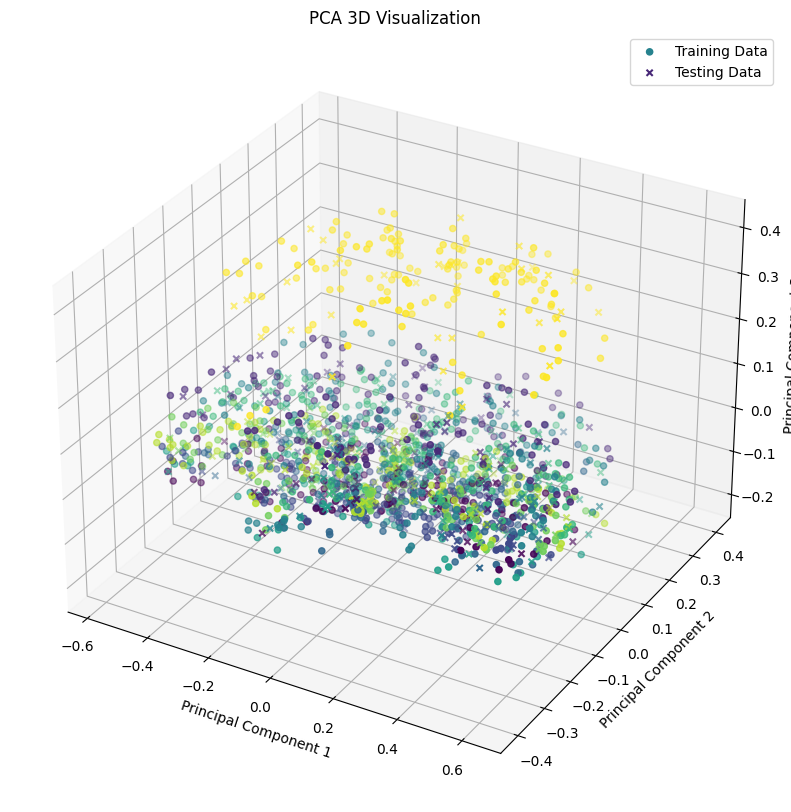

In [41]:

# Visualising
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_pca[:, 0], x_train_pca[:, 1], x_train_pca[:, 2], c=y_train, cmap='viridis', label='Training Data')
ax.scatter(x_test_pca[:, 0], x_test_pca[:, 1], x_test_pca[:, 2], c=y_test, cmap='viridis', marker='x', label='Testing Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA 3D Visualization')
ax.legend()
plt.show()

In [1]:
from sklearn.neighbors import KNeighborsClassifier

In [2]:
neigh = KNeighborsClassifier(n_neighbors=7)

In [9]:
x_test, y_test, x_train, y_train = train_test_split(normalised_dataset)

In [10]:
neigh.fit(x_test,y_test)

KNeighborsClassifier(n_neighbors=7)

In [11]:
predictions=neigh.predict(x_test)

In [13]:
sk_knn_acc=calculate_accuracy(y_test,predictions)

In [14]:
print(sk_knn_acc)

0.815


In [7]:
# Test case
x_train = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y_train = np.array(['A', 'B', 'A', 'B', 'B'])
main_point = np.array([3, 5])
k = 3

#predicted_label = calculate_euclidean(main_point, x_train, y_train, k)
predicted_label = calculate_cosine(main_point, x_train, y_train, k)

print("Predicted Label:", predicted_label)

Predicted Label: A
